# 7.2

In [1]:
!pip install matplotlib numpy
import matplotlib.pyplot as plt
import numpy as np

## Retrieve the LIGO data for the first GW detection

In [2]:
!pip install pycbc
import pycbc.catalog

In [3]:
merger = pycbc.catalog.Merger('GW150914')

In [4]:
detectors = [ 'L1', 'H1' ]

In [5]:
strain = {}
for detector in detectors:
    strain[detector] = merger.strain(detector)
    print("Loaded {} strain.".format(detector))
print("Done.")

Loaded L1 strain.
Loaded H1 strain.
Done.


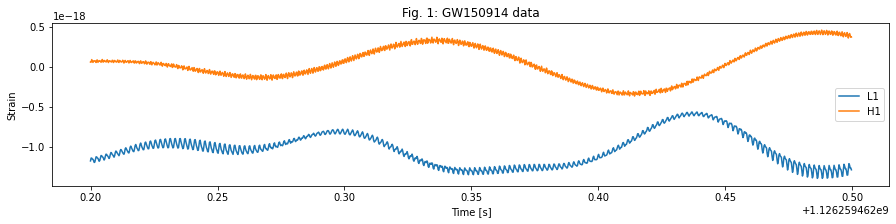

In [6]:
figstyle_timeseries = {
    'figsize': (15, 3)
}
t_zoom = (merger.time - 0.2, merger.time + 0.1)
plt.figure(**figstyle_timeseries)
for detector in detectors:
    # Zoom around the merger
    zoom = strain[detector].time_slice(*t_zoom)
    plt.plot(zoom.sample_times, zoom, label=detector)
plt.title('Fig. 1: GW150914 data')
plt.xlabel("Time [s]")
plt.ylabel("Strain");
plt.legend();

## Estimate the detector sensitivity

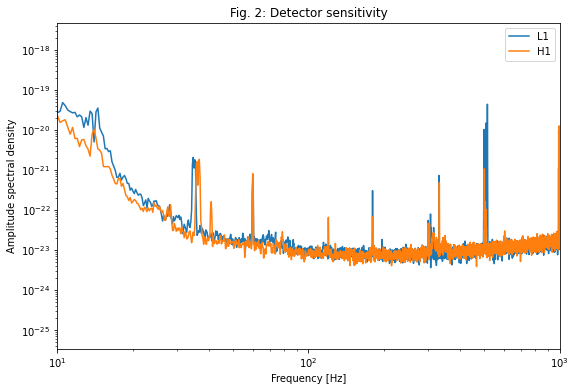

In [7]:
psd = {}
figstyle_psd = {
    'figsize': (9, 6)
}
plt.figure(**figstyle_psd)
for detector in detectors:
    # Compute the detector PSD
    psd[detector] = strain[detector].psd(4)
    plt.loglog(psd[detector].sample_frequencies, np.sqrt(psd[detector]), label=detector)
plt.xlim(1e1, 1e3)
plt.legend()
plt.title('Fig. 2: Detector sensitivity')
plt.ylabel("Amplitude spectral density")
plt.xlabel("Frequency [Hz]");

## Whiten and bandpass the strain data

In [8]:
from pycbc.psd import interpolate

In [9]:
def whiten(strain, psd):
    psd = interpolate(psd, strain.delta_f)
    return (strain.to_frequencyseries() / np.sqrt(psd)).to_timeseries()

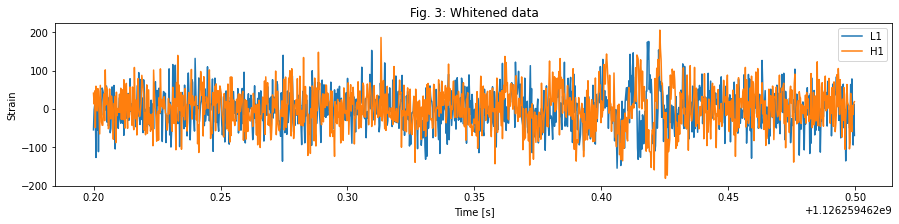

In [10]:
strain_whitened = {}
plt.figure(**figstyle_timeseries)
for detector in detectors:
    # Whiten the strain data
    strain_whitened[detector] = whiten(strain[detector], psd[detector])
    zoom = strain_whitened[detector].time_slice(*t_zoom)
    plt.plot(zoom.sample_times, zoom, label=detector)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.title("Fig. 3: Whitened data")
plt.legend();

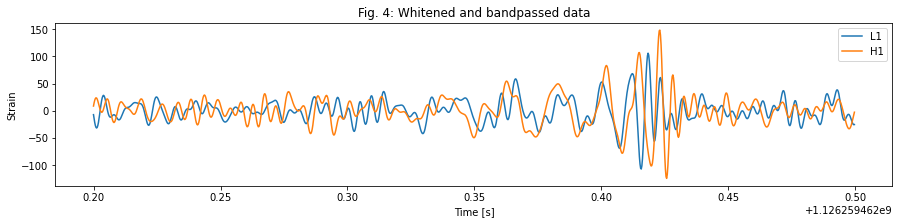

In [11]:
plt.figure(**figstyle_timeseries)
strain_bandpassed = {}
for detector in detectors:
    # Bandpass the whitened strain data
    strain_bandpassed[detector] = strain_whitened[detector].highpass_fir(frequency=30, order=512).lowpass_fir(frequency=250, order=512)
    zoom = strain_bandpassed[detector].time_slice(*t_zoom)
    plt.plot(zoom.sample_times, zoom, label=detector)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.title("Fig. 4: Whitened and bandpassed data")
plt.legend();

# Matched filtering

In [12]:
from pycbc.psd import inverse_spectrum_truncation

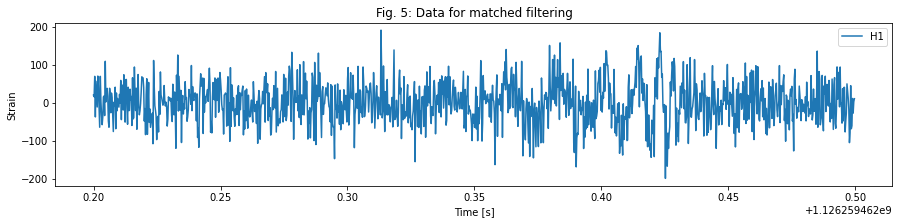

In [14]:
# Just apply a highpass filter and crop to make sure we get no boundary artifacts
strain_preconditioned = strain['H1'].highpass_fir(15.0, 512).crop(2, 2)

# Compute the PSD
psd_preconditioned = strain_preconditioned.psd(4)
# Interpolate to the strain frequency sampling
psd_preconditioned = interpolate(psd_preconditioned, strain_preconditioned.delta_f)
# Cut the PSD where we applied the highpass filter
psd_preconditioned = inverse_spectrum_truncation(psd_preconditioned, int(4 * strain_preconditioned.sample_rate), low_frequency_cutoff=15)

plt.figure(**figstyle_timeseries)
zoom = whiten(strain_preconditioned, psd_preconditioned).time_slice(*t_zoom)
plt.plot(zoom.sample_times, zoom, label=detector)
plt.xlabel("Time [s]")
plt.ylabel("Strain")
plt.title("Fig. 5: Data for matched filtering")
plt.legend();

In [15]:
from pycbc.waveform import get_td_waveform

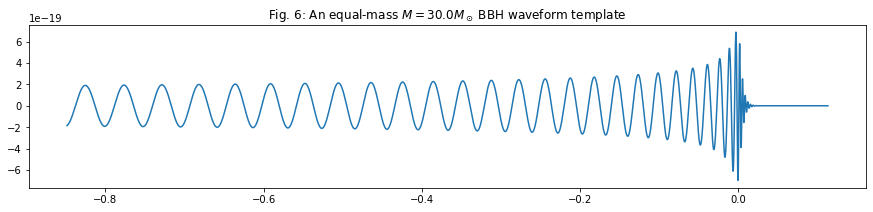

In [16]:
M = 30 # Component masses of the black-hole binary (in solar masses)
template_hplus, template_hcross = get_td_waveform(
    approximant="SEOBNRv4",
    mass1=M,
    mass2=M,
    delta_t=strain_preconditioned.delta_t,
    f_lower=20
)

plt.figure(**figstyle_timeseries)
plt.title("Fig. 6: An equal-mass $M={:.1f}M_\odot$ BBH waveform template".format(M))
plt.plot(template_hplus.sample_times, template_hplus);

In [17]:
from pycbc.filter import (matched_filter as pycbc_matched_filter, sigma)

In [18]:
def matched_filter(template, data, psd):
    # Shift template around so that it has the same length as data, but keep its merger at time 0.
    template.resize(len(strain_preconditioned))
    template = template.cyclic_time_shift(template.start_time)

    # Perform the matched filtering
    matched_snr = pycbc_matched_filter(
        template=template,
        data=data,
        psd=psd,
        low_frequency_cutoff=20,
    ).crop(8, 4)

    # Analyse the SNR
    peak_index = abs(matched_snr).numpy().argmax()
    peak_snr = matched_snr[peak_index]
    merger_time = matched_snr.sample_times[peak_index]
    
    # Shift the template to the merger time
    template_aligned = template.cyclic_time_shift(merger_time - data.start_time)

    # Scale the template so that it would have SNR 1 in this data
    template_aligned /= sigma(template_aligned, psd=psd, low_frequency_cutoff=20.0)

    # Scale the template amplitude and phase to the peak value
    template_aligned = (template_aligned.to_frequencyseries() * peak_snr).to_timeseries()

    # Align the start time of the template
    template_aligned.start_time = data.start_time
    
    return template_aligned, matched_snr, peak_snr

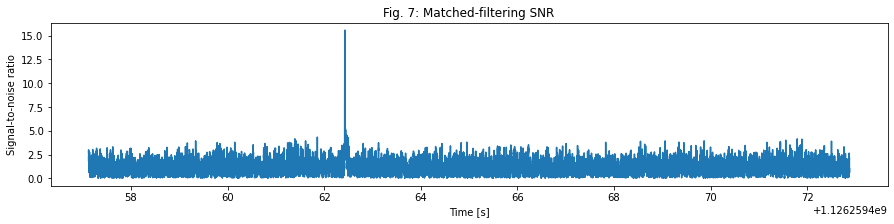

In [19]:
matched_template, matched_snr, _ = matched_filter(template_hplus, strain_preconditioned, psd_preconditioned)

plt.figure(**figstyle_timeseries)
plt.plot(matched_snr.sample_times, abs(matched_snr))
plt.ylabel('Signal-to-noise ratio')
plt.title("Fig. 7: Matched-filtering SNR")
plt.xlabel('Time [s]');

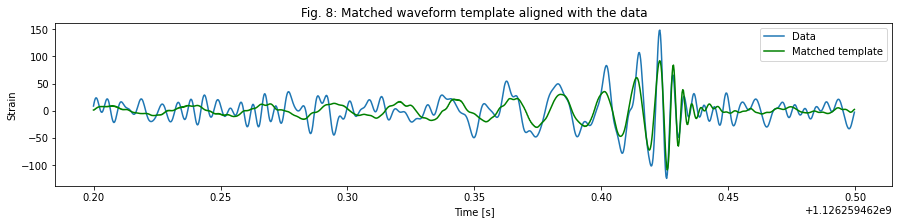

In [20]:
plt.figure(**figstyle_timeseries)

zoom_data = strain_bandpassed['H1'].time_slice(*t_zoom)
plt.plot(zoom_data.sample_times, zoom_data, label="Data")

zoom_template = whiten(matched_template, psd_preconditioned).time_slice(*t_zoom)
plt.plot(zoom_template.sample_times, zoom_template, label="Matched template", color='green')

plt.ylabel('Strain')
plt.xlabel('Time [s]')
plt.title("Fig. 8: Matched waveform template aligned with the data")
plt.legend();

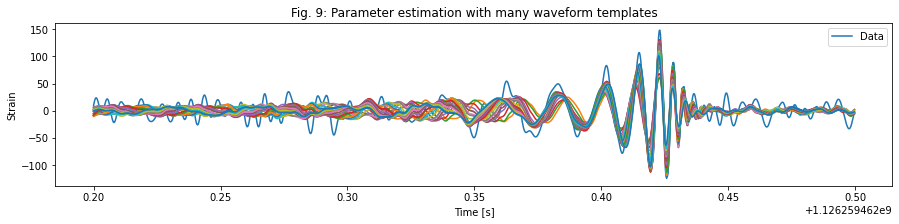

In [21]:
plt.figure(**figstyle_timeseries)

zoom_data = strain_bandpassed['H1'].time_slice(*t_zoom)
plt.plot(zoom_data.sample_times, zoom_data, label="Data")

snrs = []

masses = np.linspace(25, 45, 20)
for mass in masses:
    template, _ = get_td_waveform(
        approximant="SEOBNRv4",
        mass1=mass,
        mass2=mass,
        delta_t=strain_preconditioned.delta_t,
        f_lower=20
    )
    matched_template, _, peak_snr = matched_filter(template, strain_preconditioned, psd_preconditioned)
    snrs.append(abs(peak_snr))
    
    zoom_template = whiten(matched_template, psd_preconditioned).time_slice(*t_zoom)
    plt.plot(zoom_template.sample_times, zoom_template)

plt.ylabel('Strain')
plt.xlabel('Time [s]')
plt.title("Fig. 9: Parameter estimation with many waveform templates")
plt.legend();

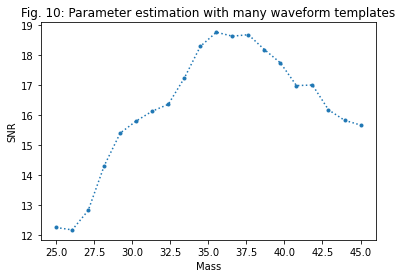

In [22]:
plt.plot(masses, snrs, marker='.', ls='dotted')
plt.xlabel("Mass")
plt.title("Fig. 10: Parameter estimation with many waveform templates")
plt.ylabel("SNR");

## h.) 

Use the methods demonstrated above to see if you can calculate the SNR time series of the five data sets provided. What is the SNR of each signal? Which template matched which data?

Information that may be useful:

    Signals are all placed between 100 and 120 seconds into the frame file.
    You may assume mass1 = mass2 (equal mass) and that each component mass is one of 22, 36, or 50.
    Each file starts at gps time 0, and ends at gps time 128
    The channel name in each file is "H1:TEST-STRAIN"


In [ ]:
# example of reading the strain in
ts = pycbc.frame.read_frame('PyCBC_T2_0.gwf', 'H1:TEST-STRAIN', 0, 128)

# Exercise 7.2

In the lecture you were shown this image which depicts the gravitational wave strains of a collection of sources and the approximate sensitivity curve of LIGO, both in the frequency domain. 

![title](image.png)

These signals were computed using a first-order post-Newtonian expansion which is a decent approximation during the initial phases of the inspiral but start to fail near merger. We will therefore try and  plot a better curve using the numerical tools available to us and the library pyCBC. You can generate waveforms with PyCBC exactly as in the previous question.

Derive the plot shown above for the following systems:

- a 50+50 solar mass binary black hole system
- GW150914
- GW200115 (see https://iopscience.iop.org/article/10.3847/2041-8213/ac082e)

In your plot you should include the noise curve of LIGO (you may take the one from GW150914 as in the previous question) and the gravitational wave strain of signal computed for each system (use "SEOBNRv4"). Then indicate on each strain at which frequency the system is 1s, 10s and 100s before merger as well, as well as the frequency 10 and 100 orbits before merger. 

You may find the following methods useful:

- hp.to_frequencyseries(): a method for a fast Fourier transform
- pycbc.waveform.utils.frequency_from_polarizations() calculates the frequency from the two polarization strains